Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1InFG9u6SJZJfUsEr6A-oqvvI_oZJl6d9'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1d32cwSV9lmpIxhBhSwtDo27GB9K3XQYb'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13867
Number of dev sentences:  2448
Number of test sentences:  27625
Number of words in the training dataset:  14450
Number of words in the dev dataset:  5242
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-treatment', 'B-test', 'B-treatment', 'O', 'I-problem', 'B-problem', 'I-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-treatment', 'B-test', 'B-treatment', 'O', 'I-problem', 'B-problem', 'I-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-treatment', 'B-test', 'B-treatment', 'O', 'I-problem', 'B-problem', 'I-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 5851,0802338,O
1,Sentence: 15815,The,O
2,Sentence: 15815,visualized,O
3,Sentence: 15815,paranasal,O
4,Sentence: 15815,sinuses,O
5,Sentence: 15815,are,O
6,Sentence: 15815,clear,O
7,Sentence: 15815,.,O
8,Sentence: 4203,Chem-7,B-test
9,Sentence: 4203,:,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Admission', 'O'), ('Date', 'O'), (':', 'O')]

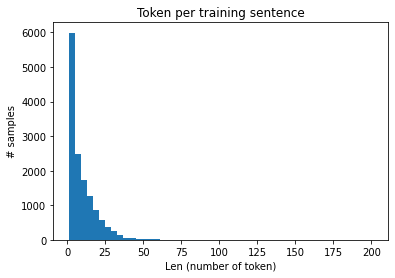

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

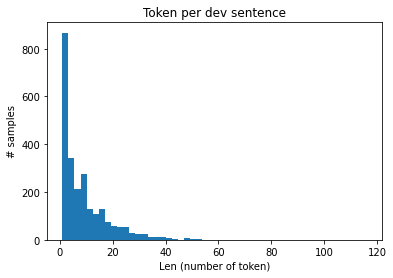

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

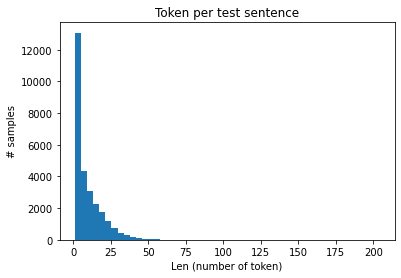

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

8790
ABUSE
2
I-problem


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.75)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13867
Points in y_train before removal: 13867
Points in X_train before removal: 3467
Points in y_train before removal: 3467


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[4746, 9704, 21760, 8691, 7383, 9006, 25035, 10936, 11583, 21988, 11657, 20116]
[3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3]
[13353, 2352, 816, 2178, 17061, 11254, 10558, 12841, 8129, 6559, 14026, 20116]
[5, 4, 4, 4, 4, 4, 3, 1, 6, 6, 6, 3]
[1533, 503, 14451]
[3, 3, 3]
8790
2
B-treatment
MWMC
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.0 MB/s 
     |████████████████████████████████| 120 kB 80.3 MB/s 
     |████████████████████████████████| 6.6 MB 71.1 MB/s 


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=746f9141d40ada7d38beef61d720ac533f31c5369e62132974590147fa55e1a4
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4746, 9704, 21760, 8691, 7383, 9006, 25035, 10936, 11583, 21988, 11657, 20116]
[3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3]
[13353, 2352, 816, 2178, 17061, 11254, 10558, 12841, 8129, 6559, 14026, 20116]
[5, 4, 4, 4, 4, 4, 3, 1, 6, 6, 6, 3]
[1533, 503, 14451]
[3, 3, 3]
8790
2
B-treatment
MWMC
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0954253673553467
Training loss per 100 training steps: 0.3836937425012636
Training loss epoch: 0.3729652216264961
Training accuracy epoch: 0.8853645874738748
Validating model...
Validation Loss: 0.19494311983225407
Validation Accuracy: 0.9373792724885321
Training epoch: 2
Training loss per 100 training steps: 0.1155339851975441
Training loss per 100 training steps: 0.1275463127300586
Training loss epoch: 0.12529629791890262
Training accuracy epoch: 0.9611358427400567
Validating model...
Validation Loss: 0.1801246792174779
Validation Accuracy: 0.9471078494255029
Training epoch: 3
Training loss per 100 training steps: 0.0866653174161911
Training loss per 100 training steps: 0.06149983335065075
Training loss epoch: 0.061969281131521274
Training accuracy epoch: 0.9813820160476601
Validating model...
Validation Loss: 0.1886732162206204
Validation Accuracy: 0.94669317047851
Training epoch: 4
Training loss per 100 training steps: 0.139

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1942877112780008
Validation Accuracy: 0.9430305668376265
Validation duration: 3.389242216666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

     problem       0.74      0.84      0.79     12546
        test       0.86      0.81      0.83      9012
   treatment       0.81      0.81      0.81      9297

   micro avg       0.79      0.82      0.81     30855
   macro avg       0.80      0.82      0.81     30855
weighted avg       0.80      0.82      0.81     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8057119846343994
Training loss per 100 training steps: 0.3783361357775065
Training loss epoch: 0.36479247737368314
Training accuracy epoch: 0.887808893012501
Validating model...
Validation Loss: 0.21196008410740208
Validation Accuracy: 0.9333673014473693
Training epoch: 2
Training loss per 100 training steps: 0.061930060386657715
Training loss per 100 training steps: 0.12920165004780387
Training loss epoch: 0.12860209031731162
Training accuracy epoch: 0.9588036407540348
Validating model...
Validation Loss: 0.15600347030278924
Validation Accuracy: 0.9515808310266117
Training epoch: 3
Training loss per 100 training steps: 0.04420815035700798
Training loss per 100 training steps: 0.07029721313294503
Training loss epoch: 0.06796421470342699
Training accuracy epoch: 0.9803158473270468
Validating model...
Validation Loss: 0.16928318118700733
Validation Accuracy: 0.9518118654882678
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17363272539201985
Validation Accuracy: 0.9464420375296088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.192751416666666 minutes
F1-score (test): 81.2%
              precision    recall  f1-score   support

     problem       0.78      0.82      0.80     12546
        test       0.84      0.83      0.84      9012
   treatment       0.78      0.84      0.81      9297

   micro avg       0.80      0.83      0.81     30855
   macro avg       0.80      0.83      0.81     30855
weighted avg       0.80      0.83      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1794328689575195
Training loss per 100 training steps: 0.3995041891489879
Training loss epoch: 0.38811384736124527
Training accuracy epoch: 0.881346546343645
Validating model...
Validation Loss: 0.2216380254014746
Validation Accuracy: 0.9287238673389238
Training epoch: 2
Training loss per 100 training steps: 0.12250955402851105
Training loss per 100 training steps: 0.12169165057268473
Stopping epoch...
Training loss epoch: 0.12169165057268473
Training accuracy epoch: 0.9518982338118015
Validating model...
Validation Loss: 0.19821223548867486
Validation Accuracy: 0.9436018585351955
Training epoch: 3
Training loss per 100 training steps: 0.03730199858546257
Training loss per 100 training steps: 0.06192444341423193
Training loss epoch: 0.06265789000402897
Training accuracy epoch: 0.9811842891416076
Validating model...
Validation Loss: 0.1842592860293853
Validation Accuracy: 0.9506928168947512
Training epoch: 4
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19117362569172489
Validation Accuracy: 0.9483407475957014
Validation duration: 3.185807399999999 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.9%
              precision    recall  f1-score   support

     problem       0.80      0.82      0.81     12546
        test       0.80      0.88      0.83      9012
   treatment       0.80      0.83      0.82      9297

   micro avg       0.80      0.84      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.84      0.82     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.072045087814331
Training loss per 100 training steps: 0.3800630800352238
Training loss epoch: 0.3647091244133787
Training accuracy epoch: 0.8878966921926847
Validating model...
Validation Loss: 0.20285151782747987
Validation Accuracy: 0.9387876227384935
Training epoch: 2
Training loss per 100 training steps: 0.12291032820940018
Training loss per 100 training steps: 0.11888957287341652
Training loss epoch: 0.11849662380019596
Training accuracy epoch: 0.9639042724078323
Validating model...
Validation Loss: 0.17608418301134915
Validation Accuracy: 0.9475374620390439
Training epoch: 3
Training loss per 100 training steps: 0.052941933274269104
Training loss per 100 training steps: 0.05856936206893608
Training loss epoch: 0.058092343027130997
Training accuracy epoch: 0.9823890707427865
Validating model...
Validation Loss: 0.1973151197390897
Validation Accuracy: 0.9473874981800063
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18553257300475337
Validation Accuracy: 0.9459582303183076
Validation duration: 3.182008533333336 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.5%
              precision    recall  f1-score   support

     problem       0.81      0.78      0.79     12546
        test       0.80      0.83      0.82      9012
   treatment       0.80      0.82      0.81      9297

   micro avg       0.80      0.81      0.81     30855
   macro avg       0.80      0.81      0.81     30855
weighted avg       0.80      0.81      0.81     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1732022762298584
Training loss per 100 training steps: 0.38670203547076426
Training loss epoch: 0.37409872985487685
Training accuracy epoch: 0.8847050347938539
Validating model...
Validation Loss: 0.1939391466704282
Validation Accuracy: 0.9391791449421322
Training epoch: 2
Training loss per 100 training steps: 0.0937771201133728
Training loss per 100 training steps: 0.12087974431786207
Training loss epoch: 0.11912091170360736
Training accuracy epoch: 0.9628945454415264
Validating model...
Validation Loss: 0.15803883587578674
Validation Accuracy: 0.949662271976611
Training epoch: 3
Training loss per 100 training steps: 0.0663006380200386
Training loss per 100 training steps: 0.05285475460240747
Training loss epoch: 0.05301047849614139
Training accuracy epoch: 0.9838735090299031
Validating model...
Validation Loss: 0.17198603150325936
Validation Accuracy: 0.9522946511925565
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16705684834677312
Validation Accuracy: 0.9481088194419889
Validation duration: 3.1832666166666663 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.77      0.81      0.79     12546
        test       0.84      0.85      0.85      9012
   treatment       0.76      0.86      0.81      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.84      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0566227436065674
Training loss per 100 training steps: 0.39832526932258416
Training loss epoch: 0.38137806883645714
Training accuracy epoch: 0.8834685401325796
Validating model...
Validation Loss: 0.19154689223928886
Validation Accuracy: 0.9387298435174853
Training epoch: 2
Training loss per 100 training steps: 0.11094294488430023
Training loss per 100 training steps: 0.12033944588043902
Training loss epoch: 0.11931619897416425
Training accuracy epoch: 0.9619801830262704
Validating model...
Validation Loss: 0.190988787776464
Validation Accuracy: 0.944654235120266
Training epoch: 3
Training loss per 100 training steps: 0.036155860871076584
Training loss per 100 training steps: 0.059444921275619234
Training loss epoch: 0.05851040032068524
Training accuracy epoch: 0.9821657062839776
Validating model...
Validation Loss: 0.20209986934220636
Validation Accuracy: 0.9454771355064617
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2019994640895338
Validation Accuracy: 0.9423829712159326
Validation duration: 3.1797494666666655 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.77      0.82      0.80     12546
        test       0.83      0.80      0.81      9012
   treatment       0.85      0.76      0.80      9297

   micro avg       0.81      0.80      0.80     30855
   macro avg       0.82      0.79      0.80     30855
weighted avg       0.81      0.80      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.816103219985962
Training loss per 100 training steps: 0.39142133524217226
Training loss epoch: 0.3785612863411597
Training accuracy epoch: 0.8848427104085677
Validating model...
Validation Loss: 0.18208278028608918
Validation Accuracy: 0.9425728698930637
Training epoch: 2
Training loss per 100 training steps: 0.1674332171678543
Training loss per 100 training steps: 0.12216960201685381
Training loss epoch: 0.12220044835650046
Training accuracy epoch: 0.9621242611949383
Validating model...
Validation Loss: 0.22401117925326547
Validation Accuracy: 0.93629910703694
Training epoch: 3
Training loss per 100 training steps: 0.08656466007232666
Training loss per 100 training steps: 0.07006559480387385
Training loss epoch: 0.0693388511042256
Training accuracy epoch: 0.9790026454254396
Validating model...
Validation Loss: 0.1924237321832447
Validation Accuracy: 0.9468000859104808
Training epoch: 4
Training loss per 100 training steps: 0.01

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19106393898578566
Validation Accuracy: 0.9393840447176871
Validation duration: 3.17772396666666 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.3%
              precision    recall  f1-score   support

     problem       0.74      0.79      0.76     12546
        test       0.80      0.78      0.79      9012
   treatment       0.77      0.79      0.78      9297

   micro avg       0.76      0.79      0.77     30855
   macro avg       0.77      0.79      0.78     30855
weighted avg       0.76      0.79      0.77     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1416311264038086
Training loss per 100 training steps: 0.39897986021962495
Training loss epoch: 0.38128507103121606
Training accuracy epoch: 0.8825036627262322
Validating model...
Validation Loss: 0.19341320844439716
Validation Accuracy: 0.9378323542441697
Training epoch: 2
Training loss per 100 training steps: 0.11867176741361618
Training loss per 100 training steps: 0.12078203294094246
Training loss epoch: 0.12076817779297676
Training accuracy epoch: 0.9628505625093805
Validating model...
Validation Loss: 0.1776020834585289
Validation Accuracy: 0.9481611164398027
Training epoch: 3
Training loss per 100 training steps: 0.040564149618148804
Training loss per 100 training steps: 0.0642538278889243
Training loss epoch: 0.06399216355943899
Training accuracy epoch: 0.9807688017716897
Validating model...
Validation Loss: 0.17279659926455904
Validation Accuracy: 0.9519379727563636
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18880751833569742
Validation Accuracy: 0.9481501942307979
Validation duration: 3.174896750000001 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.7%
              precision    recall  f1-score   support

     problem       0.79      0.85      0.82     12546
        test       0.82      0.86      0.84      9012
   treatment       0.82      0.83      0.82      9297

   micro avg       0.81      0.85      0.83     30855
   macro avg       0.81      0.85      0.83     30855
weighted avg       0.81      0.85      0.83     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8666067123413086
Training loss per 100 training steps: 0.37422225705467826
Training loss epoch: 0.3621679329817448
Training accuracy epoch: 0.8887172949518528
Validating model...
Validation Loss: 0.1784462733315183
Validation Accuracy: 0.9446331693726323
Training epoch: 2
Training loss per 100 training steps: 0.1555320918560028
Training loss per 100 training steps: 0.11695796590630371
Training loss epoch: 0.116351778114881
Training accuracy epoch: 0.9649104482317923
Validating model...
Validation Loss: 0.16599672319149816
Validation Accuracy: 0.9492082440234862
Training epoch: 3
Training loss per 100 training steps: 0.07683815062046051
Training loss per 100 training steps: 0.059100346930214376
Training loss epoch: 0.05867810012054963
Training accuracy epoch: 0.9831491757855905
Validating model...
Validation Loss: 0.19570768624544144
Validation Accuracy: 0.9482873282751506
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17846317304173243
Validation Accuracy: 0.9460806109843257
Validation duration: 3.1823478666666687 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.76      0.84      0.80     12546
        test       0.85      0.84      0.85      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.81      0.84      0.82     30855
   macro avg       0.81      0.83      0.82     30855
weighted avg       0.81      0.84      0.82     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3467
Points in y_train after augmentation: 3467
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.194659471511841
Training loss per 100 training steps: 0.3953119723661111
Training loss epoch: 0.37908088094597564
Training accuracy epoch: 0.8857180775678981
Validating model...
Validation Loss: 0.19336465601023142
Validation Accuracy: 0.9387813291888084
Training epoch: 2
Training loss per 100 training steps: 0.1556810438632965
Training loss per 100 training steps: 0.11305697195895828
Training loss epoch: 0.11219803425013472
Training accuracy epoch: 0.9655750032523287
Validating model...
Validation Loss: 0.1616995522824975
Validation Accuracy: 0.9518450455785601
Training epoch: 3
Training loss per 100 training steps: 0.026363059878349304
Training loss per 100 training steps: 0.05691284492224603
Training loss epoch: 0.058063354919912345
Training accuracy epoch: 0.9832651955383983
Validating model...
Validation Loss: 0.19057300570723298
Validation Accuracy: 0.947517540208345
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1725139350024552
Validation Accuracy: 0.9478259079751669
Validation duration: 3.174306716666676 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 82.0%
              precision    recall  f1-score   support

     problem       0.78      0.85      0.81     12546
        test       0.83      0.85      0.84      9012
   treatment       0.76      0.86      0.81      9297

   micro avg       0.79      0.85      0.82     30855
   macro avg       0.79      0.85      0.82     30855
weighted avg       0.79      0.85      0.82     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.280489444732666
Training loss per 100 training steps: 0.4100594020052121
Training loss epoch: 0.3504402894417153
Training accuracy epoch: 0.8930815149319148
Validating model...
Validation Loss: 0.18353157156667152
Validation Accuracy: 0.9414574326159173
Training epoch: 2
Training loss per 100 training steps: 0.19144827127456665
Training loss per 100 training steps: 0.10577969620059623
Training loss epoch: 0.10671399422811673
Training accuracy epoch: 0.9679165099380084
Validating model...
Validation Loss: 0.1947571558805255
Validation Accuracy: 0.9434044441967748
Training epoch: 3
Training loss per 100 training steps: 0.08748741447925568
Training loss per 100 training steps: 0.05264685805057093
Training loss epoch: 0.04879426121752819
Training accuracy epoch: 0.9856404287061764
Validating model...
Validation Loss: 0.21283664498720076
Validation Accuracy: 0.9462151234351468
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19201642971623828
Validation Accuracy: 0.9378685921686909
Validation duration: 3.1722690833333522 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.4%
              precision    recall  f1-score   support

     problem       0.71      0.84      0.77     12546
        test       0.82      0.82      0.82      9012
   treatment       0.80      0.75      0.77      9297

   micro avg       0.76      0.81      0.78     30855
   macro avg       0.77      0.80      0.79     30855
weighted avg       0.77      0.81      0.78     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.108424186706543
Training loss per 100 training steps: 0.38246087058640943
Training loss epoch: 0.334014241474078
Training accuracy epoch: 0.8967517142940961
Validating model...
Validation Loss: 0.19612680327195625
Validation Accuracy: 0.9361512700919952
Training epoch: 2
Training loss per 100 training steps: 0.18860489130020142
Training loss per 100 training steps: 0.10407541041253227
Training loss epoch: 0.10561859724111855
Training accuracy epoch: 0.9680740824769891
Validating model...
Validation Loss: 0.16779359130116253
Validation Accuracy: 0.9462578327961065
Training epoch: 3
Training loss per 100 training steps: 0.11683673411607742
Training loss per 100 training steps: 0.048856671337075164
Training loss epoch: 0.048606733038254524
Training accuracy epoch: 0.9857104576029149
Validating model...
Validation Loss: 0.1936536379303638
Validation Accuracy: 0.9514783178033188
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18123467599852355
Validation Accuracy: 0.9437627532462879
Validation duration: 3.1671821166666634 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.5%
              precision    recall  f1-score   support

     problem       0.73      0.83      0.78     12546
        test       0.81      0.82      0.82      9012
   treatment       0.79      0.82      0.80      9297

   micro avg       0.77      0.82      0.80     30855
   macro avg       0.78      0.82      0.80     30855
weighted avg       0.77      0.82      0.80     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.044140577316284
Training loss per 100 training steps: 0.3959729466402885
Training loss epoch: 0.3488657358376419
Training accuracy epoch: 0.8928486288109854
Validating model...
Validation Loss: 0.18731586252907653
Validation Accuracy: 0.9403074986161717
Training epoch: 2
Training loss per 100 training steps: 0.09521658718585968
Training loss per 100 training steps: 0.10980823213732478
Training loss epoch: 0.11195935882792316
Training accuracy epoch: 0.9653980671231639
Validating model...
Validation Loss: 0.17243894944330315
Validation Accuracy: 0.9480494265664229
Training epoch: 3
Training loss per 100 training steps: 0.01988217420876026
Training loss per 100 training steps: 0.056606284859083075
Training loss epoch: 0.05705501530867289
Training accuracy epoch: 0.9825434798954691
Validating model...
Validation Loss: 0.2109489201435021
Validation Accuracy: 0.9460950722293078
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1771597300345699
Validation Accuracy: 0.9467069035941248
Validation duration: 3.1612573500000205 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.8%
              precision    recall  f1-score   support

     problem       0.77      0.82      0.79     12546
        test       0.77      0.80      0.79      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.78      0.82      0.80     30855
   macro avg       0.78      0.82      0.80     30855
weighted avg       0.78      0.82      0.80     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0159897804260254
Training loss per 100 training steps: 0.3773655969612669
Training loss epoch: 0.32792945469126983
Training accuracy epoch: 0.8966846277425898
Validating model...
Validation Loss: 0.17760895081348232
Validation Accuracy: 0.9439021525815022
Training epoch: 2
Training loss per 100 training steps: 0.14910732209682465
Training loss per 100 training steps: 0.10717570492167874
Training loss epoch: 0.10572642481009312
Training accuracy epoch: 0.9670604787377284
Validating model...
Validation Loss: 0.16999377644100747
Validation Accuracy: 0.9473796205234668
Training epoch: 3
Training loss per 100 training steps: 0.047456443309783936
Training loss per 100 training steps: 0.04930141618899485
Training loss epoch: 0.049452817978282625
Training accuracy epoch: 0.9854238647969015
Validating model...
Validation Loss: 0.19828076097001504
Validation Accuracy: 0.9472443959700397
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.177844505239692
Validation Accuracy: 0.9454134882470333
Validation duration: 3.1644660333333072 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

     problem       0.76      0.84      0.80     12546
        test       0.81      0.85      0.83      9012
   treatment       0.81      0.83      0.82      9297

   micro avg       0.79      0.84      0.81     30855
   macro avg       0.79      0.84      0.82     30855
weighted avg       0.79      0.84      0.81     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7377513647079468
Training loss per 100 training steps: 0.3897739971923356
Training loss epoch: 0.33605864742661223
Training accuracy epoch: 0.8969039740356977
Validating model...
Validation Loss: 0.20243397906616137
Validation Accuracy: 0.9364663408401137
Training epoch: 2
Training loss per 100 training steps: 0.09995797276496887
Training loss per 100 training steps: 0.11792438871937223
Training loss epoch: 0.1211822668556124
Training accuracy epoch: 0.9632839147936613
Validating model...
Validation Loss: 0.16904607540988303
Validation Accuracy: 0.9481716931232331
Training epoch: 3
Training loss per 100 training steps: 0.04096001386642456
Training loss per 100 training steps: 0.05292817684683469
Training loss epoch: 0.05511368143796811
Training accuracy epoch: 0.9831531302471681
Validating model...
Validation Loss: 0.177859538319436
Validation Accuracy: 0.9492487655090712
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18134280909672035
Validation Accuracy: 0.9445766341569777
Validation duration: 3.1673953333333276 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.5%
              precision    recall  f1-score   support

     problem       0.76      0.83      0.79     12546
        test       0.79      0.87      0.83      9012
   treatment       0.76      0.84      0.80      9297

   micro avg       0.77      0.84      0.80     30855
   macro avg       0.77      0.85      0.81     30855
weighted avg       0.77      0.84      0.80     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9139020442962646
Training loss per 100 training steps: 0.37371470137397844
Training loss epoch: 0.3284132068648058
Training accuracy epoch: 0.8990837635237592
Validating model...
Validation Loss: 0.18735673791402346
Validation Accuracy: 0.9400547590141651
Training epoch: 2
Training loss per 100 training steps: 0.15980280935764313
Training loss per 100 training steps: 0.10772942790374307
Training loss epoch: 0.10590616100714267
Training accuracy epoch: 0.9676183316736342
Validating model...
Validation Loss: 0.1715578053678785
Validation Accuracy: 0.9450756643035548
Training epoch: 3
Training loss per 100 training steps: 0.04596330225467682
Training loss per 100 training steps: 0.055366664940472876
Training loss epoch: 0.055975423975135476
Training accuracy epoch: 0.9836142626055749
Validating model...
Validation Loss: 0.1938745878007892
Validation Accuracy: 0.9470492785986525
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17501364280879325
Validation Accuracy: 0.9462446757960565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1677730000000035 minutes
F1-score (test): 81.0%
              precision    recall  f1-score   support

     problem       0.78      0.82      0.80     12546
        test       0.82      0.83      0.82      9012
   treatment       0.80      0.82      0.81      9297

   micro avg       0.80      0.82      0.81     30855
   macro avg       0.80      0.82      0.81     30855
weighted avg       0.80      0.82      0.81     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.893501877784729
Training loss per 100 training steps: 0.3883792797085082
Training loss epoch: 0.33509378743303175
Training accuracy epoch: 0.8968567013334333
Validating model...
Validation Loss: 0.18141106487094583
Validation Accuracy: 0.9413684087698186
Training epoch: 2
Training loss per 100 training steps: 0.07652639597654343
Training loss per 100 training steps: 0.10727478353546398
Training loss epoch: 0.10811220664147507
Training accuracy epoch: 0.9677080535088035
Validating model...
Validation Loss: 0.18241087579494947
Validation Accuracy: 0.9454661945026099
Training epoch: 3
Training loss per 100 training steps: 0.12517386674880981
Training loss per 100 training steps: 0.04899170632372693
Training loss epoch: 0.05137991489198826
Training accuracy epoch: 0.9847850173200612
Validating model...
Validation Loss: 0.18719110850776946
Validation Accuracy: 0.9481586244846207
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18740896237970986
Validation Accuracy: 0.9409583609974561
Validation duration: 3.1599758666666578 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.1%
              precision    recall  f1-score   support

     problem       0.74      0.78      0.76     12546
        test       0.82      0.83      0.83      9012
   treatment       0.77      0.84      0.80      9297

   micro avg       0.77      0.81      0.79     30855
   macro avg       0.78      0.81      0.80     30855
weighted avg       0.77      0.81      0.79     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9125477075576782
Training loss per 100 training steps: 0.388033764418399
Training loss epoch: 0.3395857648814426
Training accuracy epoch: 0.8954860710903916
Validating model...
Validation Loss: 0.19156348231163892
Validation Accuracy: 0.9374464348975171
Training epoch: 2
Training loss per 100 training steps: 0.09450244903564453
Training loss per 100 training steps: 0.11424218129255984
Training loss epoch: 0.10929711699924048
Training accuracy epoch: 0.9661553772942004
Validating model...
Validation Loss: 0.1741610166507882
Validation Accuracy: 0.9477766376415016
Training epoch: 3
Training loss per 100 training steps: 0.041079096496105194
Training loss per 100 training steps: 0.053850771983771924
Training loss epoch: 0.0555388098822304
Training accuracy epoch: 0.9827909491368694
Validating model...
Validation Loss: 0.19635034594442938
Validation Accuracy: 0.9467100905846825
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18039353619139917
Validation Accuracy: 0.9460902764511688
Validation duration: 3.164926666666664 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.77      0.83      0.80     12546
        test       0.83      0.83      0.83      9012
   treatment       0.78      0.85      0.82      9297

   micro avg       0.79      0.84      0.81     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.79      0.84      0.81     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7633130550384521
Training loss per 100 training steps: 0.4045660295108757
Training loss epoch: 0.3367556322585134
Training accuracy epoch: 0.89602194837872
Validating model...
Validation Loss: 0.18661882931535895
Validation Accuracy: 0.9428884358449505
Training epoch: 2
Training loss per 100 training steps: 0.0529225692152977
Training loss per 100 training steps: 0.1049117018459457
Training loss epoch: 0.10305003680781845
Training accuracy epoch: 0.9676968947877377
Validating model...
Validation Loss: 0.17342678351061686
Validation Accuracy: 0.9466245489057852
Training epoch: 3
Training loss per 100 training steps: 0.13384823501110077
Training loss per 100 training steps: 0.059918823914768375
Training loss epoch: 0.05602737501441665
Training accuracy epoch: 0.9834088186764947
Validating model...
Validation Loss: 0.20900699138254314
Validation Accuracy: 0.948587314149323
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18895651744592382
Validation Accuracy: 0.9429272773182257
Validation duration: 3.162934283333349 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.76      0.84      0.80     12546
        test       0.82      0.82      0.82      9012
   treatment       0.75      0.85      0.79      9297

   micro avg       0.77      0.84      0.80     30855
   macro avg       0.78      0.84      0.80     30855
weighted avg       0.77      0.84      0.80     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.022265672683716
Training loss per 100 training steps: 0.3889044635366685
Training loss epoch: 0.3338888618711601
Training accuracy epoch: 0.8965909576501767
Validating model...
Validation Loss: 0.1962658730033156
Validation Accuracy: 0.9391054966991421
Training epoch: 2
Training loss per 100 training steps: 0.09108991175889969
Training loss per 100 training steps: 0.10572935076485766
Training loss epoch: 0.10144963701639105
Training accuracy epoch: 0.9694163954847634
Validating model...
Validation Loss: 0.17693559036819967
Validation Accuracy: 0.945352638512974
Training epoch: 3
Training loss per 100 training steps: 0.08422933518886566
Training loss per 100 training steps: 0.052902836186608466
Training loss epoch: 0.05632888423689805
Training accuracy epoch: 0.9825255465092726
Validating model...
Validation Loss: 0.20174807283495153
Validation Accuracy: 0.9455948057003347
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1856414605302874
Validation Accuracy: 0.9447490605224643
Validation duration: 3.161670799999956 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.74      0.82      0.78     12546
        test       0.83      0.84      0.83      9012
   treatment       0.81      0.82      0.81      9297

   micro avg       0.78      0.82      0.80     30855
   macro avg       0.79      0.82      0.81     30855
weighted avg       0.79      0.82      0.80     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2178518772125244
Training loss per 100 training steps: 0.3833032095491296
Training loss epoch: 0.30653042929029906
Training accuracy epoch: 0.9057415889084901
Validating model...
Validation Loss: 0.17683767517665763
Validation Accuracy: 0.9427782626491827
Training epoch: 2
Training loss per 100 training steps: 0.15514297783374786
Training loss per 100 training steps: 0.09349458919155716
Training loss epoch: 0.09030889280917455
Training accuracy epoch: 0.9725124856738459
Validating model...
Validation Loss: 0.1705095096938796
Validation Accuracy: 0.9478781930408476
Training epoch: 3
Training loss per 100 training steps: 0.0335363931953907
Training loss per 100 training steps: 0.04739342338525423
Training loss epoch: 0.04654255431242561
Training accuracy epoch: 0.9864097099317233
Validating model...
Validation Loss: 0.22193935254661293
Validation Accuracy: 0.9467576778244732
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18378434349627545
Validation Accuracy: 0.9454064147761364
Validation duration: 3.1619398000000123 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.1%
              precision    recall  f1-score   support

     problem       0.77      0.81      0.79     12546
        test       0.79      0.84      0.81      9012
   treatment       0.80      0.81      0.80      9297

   micro avg       0.78      0.82      0.80     30855
   macro avg       0.79      0.82      0.80     30855
weighted avg       0.78      0.82      0.80     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9486994743347168
Training loss per 100 training steps: 0.39011653748774294
Training loss epoch: 0.3119393075627783
Training accuracy epoch: 0.9026246601728772
Validating model...
Validation Loss: 0.18902744594719503
Validation Accuracy: 0.9400676549832121
Training epoch: 2
Training loss per 100 training steps: 0.07309047877788544
Training loss per 100 training steps: 0.09024849676960471
Training loss epoch: 0.09716475666414924
Training accuracy epoch: 0.9709925220761498
Validating model...
Validation Loss: 0.18432664624475814
Validation Accuracy: 0.9458532939702637
Training epoch: 3
Training loss per 100 training steps: 0.06538120657205582
Training loss per 100 training steps: 0.04709159884841578
Training loss epoch: 0.056221279238516386
Training accuracy epoch: 0.9833328850706563
Validating model...
Validation Loss: 0.19354327570937283
Validation Accuracy: 0.9431226765102306
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19051870903543508
Validation Accuracy: 0.9462381239144159
Validation duration: 3.1630138000000443 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.79      0.82      0.81     12546
        test       0.80      0.84      0.82      9012
   treatment       0.78      0.85      0.81      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.83      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.693992018699646
Training loss per 100 training steps: 0.38070190926589587
Training loss epoch: 0.30364280182616843
Training accuracy epoch: 0.9057695934012467
Validating model...
Validation Loss: 0.17751141061837022
Validation Accuracy: 0.9439190171440514
Training epoch: 2
Training loss per 100 training steps: 0.1296570599079132
Training loss per 100 training steps: 0.09309686856842277
Training loss epoch: 0.0958743859996642
Training accuracy epoch: 0.9705234854047152
Validating model...
Validation Loss: 0.18495518075568335
Validation Accuracy: 0.9468126400657146
Training epoch: 3
Training loss per 100 training steps: 0.09937135130167007
Training loss per 100 training steps: 0.048588221510042356
Training loss epoch: 0.05325612010708525
Training accuracy epoch: 0.9840781369414341
Validating model...
Validation Loss: 0.19220135573829925
Validation Accuracy: 0.9490349089721462
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18368426173563218
Validation Accuracy: 0.9414492125181536
Validation duration: 3.166767083333313 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.0%
              precision    recall  f1-score   support

     problem       0.69      0.84      0.76     12546
        test       0.84      0.81      0.82      9012
   treatment       0.80      0.82      0.81      9297

   micro avg       0.76      0.82      0.79     30855
   macro avg       0.78      0.82      0.80     30855
weighted avg       0.77      0.82      0.79     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9856966733932495
Training loss per 100 training steps: 0.4053317363751997
Training loss epoch: 0.3183641627979425
Training accuracy epoch: 0.901091441077954
Validating model...
Validation Loss: 0.18324920152882476
Validation Accuracy: 0.9408523782404735
Training epoch: 2
Training loss per 100 training steps: 0.08076894283294678
Training loss per 100 training steps: 0.0966448407288235
Training loss epoch: 0.09754628624104283
Training accuracy epoch: 0.9704976099102886
Validating model...
Validation Loss: 0.18476177389165024
Validation Accuracy: 0.946545084234876
Training epoch: 3
Training loss per 100 training steps: 0.14949962496757507
Training loss per 100 training steps: 0.04123083756093194
Training loss epoch: 0.04350863071729892
Training accuracy epoch: 0.9872353054670696
Validating model...
Validation Loss: 0.20225184522085377
Validation Accuracy: 0.9499988365867998
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18704789482850442
Validation Accuracy: 0.9393054214817816
Validation duration: 3.1619302333333206 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.0%
              precision    recall  f1-score   support

     problem       0.71      0.84      0.77     12546
        test       0.78      0.84      0.81      9012
   treatment       0.77      0.83      0.80      9297

   micro avg       0.75      0.84      0.79     30855
   macro avg       0.75      0.84      0.79     30855
weighted avg       0.75      0.84      0.79     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.074310064315796
Training loss per 100 training steps: 0.39007250404003824
Training loss epoch: 0.31253665054868335
Training accuracy epoch: 0.9049571583352507
Validating model...
Validation Loss: 0.1811354254650605
Validation Accuracy: 0.9418042562956092
Training epoch: 2
Training loss per 100 training steps: 0.21752087771892548
Training loss per 100 training steps: 0.10196758423111227
Training loss epoch: 0.09693817692620257
Training accuracy epoch: 0.9705486052160538
Validating model...
Validation Loss: 0.19300834897470165
Validation Accuracy: 0.9418210253270971
Training epoch: 3
Training loss per 100 training steps: 0.04212959110736847
Training loss per 100 training steps: 0.05172891960027489
Training loss epoch: 0.04850150867039624
Training accuracy epoch: 0.9857743214179991
Validating model...
Validation Loss: 0.20464938051708334
Validation Accuracy: 0.9473655860841513
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19157119686025437
Validation Accuracy: 0.9395305429143747
Validation duration: 3.162577883333385 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.7%
              precision    recall  f1-score   support

     problem       0.70      0.84      0.76     12546
        test       0.84      0.80      0.82      9012
   treatment       0.73      0.86      0.79      9297

   micro avg       0.75      0.83      0.79     30855
   macro avg       0.76      0.83      0.79     30855
weighted avg       0.75      0.83      0.79     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7249037027359009
Training loss per 100 training steps: 0.38943620070372476
Training loss epoch: 0.3097151450218599
Training accuracy epoch: 0.9038071054908576
Validating model...
Validation Loss: 0.18353351907103094
Validation Accuracy: 0.9423013660649664
Training epoch: 2
Training loss per 100 training steps: 0.08497332036495209
Training loss per 100 training steps: 0.1008671044860736
Training loss epoch: 0.097068805596077
Training accuracy epoch: 0.9708524239975883
Validating model...
Validation Loss: 0.185718721528719
Validation Accuracy: 0.9465104590349844
Training epoch: 3
Training loss per 100 training steps: 0.026381516829133034
Training loss per 100 training steps: 0.05292950918215631
Training loss epoch: 0.053782706706001895
Training accuracy epoch: 0.9842419118073104
Validating model...
Validation Loss: 0.22112978699725944
Validation Accuracy: 0.9457842064931825
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1831792619260442
Validation Accuracy: 0.9420713468795575
Validation duration: 3.164066383333314 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.2%
              precision    recall  f1-score   support

     problem       0.73      0.79      0.76     12546
        test       0.80      0.82      0.81      9012
   treatment       0.80      0.78      0.79      9297

   micro avg       0.77      0.80      0.78     30855
   macro avg       0.78      0.80      0.79     30855
weighted avg       0.77      0.80      0.78     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.030805826187134
Training loss per 100 training steps: 0.3911115527153015
Training loss epoch: 0.3256236717470585
Training accuracy epoch: 0.900230795170958
Validating model...
Validation Loss: 0.18386652470602619
Validation Accuracy: 0.940719406879967
Training epoch: 2
Training loss per 100 training steps: 0.2039601057767868
Training loss per 100 training steps: 0.10415096674114466
Training loss epoch: 0.10086713645013015
Training accuracy epoch: 0.9689539773991525
Validating model...
Validation Loss: 0.17431279702426553
Validation Accuracy: 0.9478646601891374
Training epoch: 3
Training loss per 100 training steps: 0.07489175349473953
Training loss per 100 training steps: 0.04559310932763585
Training loss epoch: 0.047377034457560425
Training accuracy epoch: 0.9858718957984096
Validating model...
Validation Loss: 0.20175104225417237
Validation Accuracy: 0.9489786681265268
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17471356234616703
Validation Accuracy: 0.947871187538508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1655913333333348 minutes
F1-score (test): 81.7%
              precision    recall  f1-score   support

     problem       0.80      0.82      0.81     12546
        test       0.78      0.87      0.82      9012
   treatment       0.81      0.82      0.81      9297

   micro avg       0.80      0.83      0.82     30855
   macro avg       0.80      0.84      0.82     30855
weighted avg       0.80      0.83      0.82     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7221482992172241
Training loss per 100 training steps: 0.3835645813753109
Training loss epoch: 0.3060808876540763
Training accuracy epoch: 0.9062536421563466
Validating model...
Validation Loss: 0.18450566652146252
Validation Accuracy: 0.941424431137783
Training epoch: 2
Training loss per 100 training steps: 0.0930456668138504
Training loss per 100 training steps: 0.09302776752242653
Stopping epoch...
Training loss epoch: 0.09302776752242653
Training accuracy epoch: 0.9623491760156402
Validating model...
Validation Loss: 0.18374494826058288
Validation Accuracy: 0.9455601881206098
Training epoch: 3
Training loss per 100 training steps: 0.038241196423769
Training loss per 100 training steps: 0.0643323738229378
Training loss epoch: 0.06801747061894989
Training accuracy epoch: 0.9797546982051626
Validating model...
Validation Loss: 0.19107698163549816
Validation Accuracy: 0.9474291934962458
Training epoch: 4
Training loss per 100 tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18585776186686148
Validation Accuracy: 0.946426135057211
Validation duration: 3.167145433333341 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

     problem       0.77      0.80      0.79     12546
        test       0.84      0.83      0.83      9012
   treatment       0.79      0.81      0.80      9297

   micro avg       0.80      0.81      0.80     30855
   macro avg       0.80      0.81      0.81     30855
weighted avg       0.80      0.81      0.80     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1329305171966553
Training loss per 100 training steps: 0.4058839904494805
Training loss epoch: 0.322375319075365
Training accuracy epoch: 0.899667550402931
Validating model...
Validation Loss: 0.19520500757090456
Validation Accuracy: 0.9389606483169697
Training epoch: 2
Training loss per 100 training steps: 0.16201600432395935
Training loss per 100 training steps: 0.10562550280206275
Training loss epoch: 0.10094281793372031
Training accuracy epoch: 0.969341622871785
Validating model...
Validation Loss: 0.18716295692440751
Validation Accuracy: 0.9458924524669777
Training epoch: 3
Training loss per 100 training steps: 0.021492797881364822
Training loss per 100 training steps: 0.05657697788965289
Training loss epoch: 0.05314798191749702
Training accuracy epoch: 0.9845815974506288
Validating model...
Validation Loss: 0.20967335341038643
Validation Accuracy: 0.9477108079660852
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18911992154446328
Validation Accuracy: 0.9463396578887062
Validation duration: 3.160512083333318 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.77      0.81      0.79     12546
        test       0.79      0.84      0.82      9012
   treatment       0.83      0.80      0.82      9297

   micro avg       0.79      0.82      0.80     30855
   macro avg       0.80      0.82      0.81     30855
weighted avg       0.79      0.82      0.80     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7719964981079102
Training loss per 100 training steps: 0.372043639421463
Training loss epoch: 0.299224989831539
Training accuracy epoch: 0.9087378189440616
Validating model...
Validation Loss: 0.1898078957161346
Validation Accuracy: 0.9394455627777465
Training epoch: 2
Training loss per 100 training steps: 0.13756947219371796
Training loss per 100 training steps: 0.09161761631764988
Training loss epoch: 0.0912846146048578
Training accuracy epoch: 0.9725621464503188
Validating model...
Validation Loss: 0.19782853235381764
Validation Accuracy: 0.9416398126100113
Training epoch: 3
Training loss per 100 training steps: 0.04613542556762695
Training loss per 100 training steps: 0.045100718787364144
Training loss epoch: 0.04550654317418033
Training accuracy epoch: 0.9857586340897043
Validating model...
Validation Loss: 0.20617518133737825
Validation Accuracy: 0.9487392120307224
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19016207315898673
Validation Accuracy: 0.9402299235175514
Validation duration: 3.1646500166666254 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.4%
              precision    recall  f1-score   support

     problem       0.74      0.78      0.76     12546
        test       0.76      0.85      0.81      9012
   treatment       0.80      0.78      0.79      9297

   micro avg       0.77      0.80      0.78     30855
   macro avg       0.77      0.81      0.79     30855
weighted avg       0.77      0.80      0.78     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1098246574401855
Training loss per 100 training steps: 0.392149913650338
Training loss epoch: 0.2835786074988152
Training accuracy epoch: 0.9129149447243927
Validating model...
Validation Loss: 0.17964563983214366
Validation Accuracy: 0.9429800064762875
Training epoch: 2
Training loss per 100 training steps: 0.12010766565799713
Training loss per 100 training steps: 0.0739401385907342
Training loss epoch: 0.07962466979791459
Training accuracy epoch: 0.9757887319065803
Validating model...
Validation Loss: 0.200972063152434
Validation Accuracy: 0.941641191825116
Training epoch: 3
Training loss per 100 training steps: 0.02014784887433052
Training loss per 100 training steps: 0.04054575622782554
Training loss epoch: 0.0400548310227398
Training accuracy epoch: 0.988426525129427
Validating model...
Validation Loss: 0.18472418997001339
Validation Accuracy: 0.9530553368230629
Training epoch: 4
Training loss per 100 training steps: 0.0131

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17841405889743733
Validation Accuracy: 0.9447119736334644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.167009466666665 minutes
F1-score (test): 79.7%
              precision    recall  f1-score   support

     problem       0.74      0.81      0.77     12546
        test       0.80      0.84      0.82      9012
   treatment       0.79      0.83      0.81      9297

   micro avg       0.77      0.83      0.80     30855
   macro avg       0.77      0.83      0.80     30855
weighted avg       0.77      0.83      0.80     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9686143398284912
Training loss per 100 training steps: 0.40149736913419004
Training loss epoch: 0.2955211983405446
Training accuracy epoch: 0.9121113042961302
Validating model...
Validation Loss: 0.1889682716944001
Validation Accuracy: 0.9424253341667758
Training epoch: 2
Training loss per 100 training steps: 0.17380894720554352
Training loss per 100 training steps: 0.09427840380680443
Training loss epoch: 0.09233989584210672
Training accuracy epoch: 0.9723519455293228
Validating model...
Validation Loss: 0.18078303338306678
Validation Accuracy: 0.9483536921437344
Training epoch: 3
Training loss per 100 training steps: 0.06935301423072815
Training loss per 100 training steps: 0.041826740704882556
Training loss epoch: 0.04276799181427218
Training accuracy epoch: 0.9874334548068405
Validating model...
Validation Loss: 0.23483675873124754
Validation Accuracy: 0.9419650940071298
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18845029501136634
Validation Accuracy: 0.9470712983950954
Validation duration: 3.1646123500000005 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

     problem       0.77      0.82      0.79     12546
        test       0.82      0.85      0.83      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.79      0.83      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7114226818084717
Training loss per 100 training steps: 0.36796001049846705
Training loss epoch: 0.276865165014016
Training accuracy epoch: 0.9156390429431992
Validating model...
Validation Loss: 0.20291389428175888
Validation Accuracy: 0.9369815375927958
Training epoch: 2
Training loss per 100 training steps: 0.10327329486608505
Training loss per 100 training steps: 0.08463527603388422
Training loss epoch: 0.08281348279040111
Training accuracy epoch: 0.9751220580666102
Validating model...
Validation Loss: 0.1826145759263596
Validation Accuracy: 0.9477575351663781
Training epoch: 3
Training loss per 100 training steps: 0.0615757517516613
Training loss per 100 training steps: 0.04399036508662128
Training loss epoch: 0.04397963834191231
Training accuracy epoch: 0.9866730337489777
Validating model...
Validation Loss: 0.21747250496954112
Validation Accuracy: 0.9450624089349329
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19321168474508105
Validation Accuracy: 0.9447284146408309
Validation duration: 3.1573216166666196 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

     problem       0.81      0.79      0.80     12546
        test       0.79      0.87      0.83      9012
   treatment       0.74      0.86      0.80      9297

   micro avg       0.78      0.83      0.81     30855
   macro avg       0.78      0.84      0.81     30855
weighted avg       0.78      0.83      0.81     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8594191074371338
Training loss per 100 training steps: 0.3989430023080642
Training loss epoch: 0.29360146167639056
Training accuracy epoch: 0.9096885228603877
Validating model...
Validation Loss: 0.17593279635751402
Validation Accuracy: 0.9458190620275856
Training epoch: 2
Training loss per 100 training steps: 0.08317269384860992
Training loss per 100 training steps: 0.09683735746115742
Training loss epoch: 0.09217431517808061
Training accuracy epoch: 0.9726542834214352
Validating model...
Validation Loss: 0.1954615663785439
Validation Accuracy: 0.9437885733191554
Training epoch: 3
Training loss per 100 training steps: 0.02555704303085804
Training loss per 100 training steps: 0.04665255143150392
Training loss epoch: 0.04730714127715481
Training accuracy epoch: 0.9858644272379413
Validating model...
Validation Loss: 0.1961510343259418
Validation Accuracy: 0.9470022456450081
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17994533112289868
Validation Accuracy: 0.9427069286853159
Validation duration: 3.1694050166666785 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.4%
              precision    recall  f1-score   support

     problem       0.73      0.82      0.77     12546
        test       0.83      0.82      0.82      9012
   treatment       0.75      0.85      0.80      9297

   micro avg       0.76      0.83      0.79     30855
   macro avg       0.77      0.83      0.80     30855
weighted avg       0.76      0.83      0.79     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8287848234176636
Training loss per 100 training steps: 0.3700667977480605
Training loss epoch: 0.2785134347351758
Training accuracy epoch: 0.9150334178851806
Validating model...
Validation Loss: 0.18761099570176817
Validation Accuracy: 0.9402492037544796
Training epoch: 2
Training loss per 100 training steps: 0.10355477780103683
Training loss per 100 training steps: 0.08608899158563944
Training loss epoch: 0.0860874053654506
Training accuracy epoch: 0.9738223273099899
Validating model...
Validation Loss: 0.1725606516293891
Validation Accuracy: 0.9491442631731684
Training epoch: 3
Training loss per 100 training steps: 0.04674778878688812
Training loss per 100 training steps: 0.04063665696724069
Training loss epoch: 0.039636255881602044
Training accuracy epoch: 0.98875750862672
Validating model...
Validation Loss: 0.2134218057496594
Validation Accuracy: 0.9472134125276988
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18402466275060927
Validation Accuracy: 0.9467264650320938
Validation duration: 3.163676516666722 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

     problem       0.78      0.81      0.80     12546
        test       0.80      0.86      0.83      9012
   treatment       0.80      0.83      0.82      9297

   micro avg       0.79      0.83      0.81     30855
   macro avg       0.80      0.84      0.81     30855
weighted avg       0.79      0.83      0.81     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8787955045700073
Training loss per 100 training steps: 0.3628541104274221
Training loss epoch: 0.27920132369587297
Training accuracy epoch: 0.9150038144547921
Validating model...
Validation Loss: 0.18369395430985982
Validation Accuracy: 0.9404234796281494
Training epoch: 2
Training loss per 100 training steps: 0.04901711642742157
Training loss per 100 training steps: 0.09233284599636452
Training loss epoch: 0.08698516811587309
Training accuracy epoch: 0.9726805248901891
Validating model...
Validation Loss: 0.18910163771603014
Validation Accuracy: 0.9468921690386977
Training epoch: 3
Training loss per 100 training steps: 0.06744292378425598
Training loss per 100 training steps: 0.04446499034218342
Training loss epoch: 0.04734821118242843
Training accuracy epoch: 0.9864305967452823
Validating model...
Validation Loss: 0.2119494095057636
Validation Accuracy: 0.9465924447600694
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19363247907582531
Validation Accuracy: 0.9382591324337547
Validation duration: 3.170283150000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.7%
              precision    recall  f1-score   support

     problem       0.71      0.82      0.77     12546
        test       0.79      0.74      0.76      9012
   treatment       0.78      0.83      0.81      9297

   micro avg       0.76      0.80      0.78     30855
   macro avg       0.76      0.80      0.78     30855
weighted avg       0.76      0.80      0.78     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.402829885482788
Training loss per 100 training steps: 0.3833427534318796
Training loss epoch: 0.28658436664233083
Training accuracy epoch: 0.9114160350653948
Validating model...
Validation Loss: 0.19909894282554652
Validation Accuracy: 0.9384250491522025
Training epoch: 2
Training loss per 100 training steps: 0.1533326655626297
Training loss per 100 training steps: 0.08981721995785685
Training loss epoch: 0.08313932164915298
Training accuracy epoch: 0.9752546582924528
Validating model...
Validation Loss: 0.19044327791538332
Validation Accuracy: 0.9459717205261254
Training epoch: 3
Training loss per 100 training steps: 0.05006656423211098
Training loss per 100 training steps: 0.045224738653085315
Training loss epoch: 0.039693714322914415
Training accuracy epoch: 0.9884919600815835
Validating model...
Validation Loss: 0.21202013452912305
Validation Accuracy: 0.9498212258835294
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20481655952985253
Validation Accuracy: 0.943323634515776
Validation duration: 3.1685177000000597 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.6%
              precision    recall  f1-score   support

     problem       0.76      0.82      0.79     12546
        test       0.84      0.81      0.82      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.79      0.82      0.81     30855
   macro avg       0.80      0.82      0.81     30855
weighted avg       0.79      0.82      0.81     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0507726669311523
Training loss per 100 training steps: 0.3933915037034762
Training loss epoch: 0.2931948601415283
Training accuracy epoch: 0.9105800375263927
Validating model...
Validation Loss: 0.1901492802063366
Validation Accuracy: 0.9407508810946664
Training epoch: 2
Training loss per 100 training steps: 0.10431142151355743
Training loss per 100 training steps: 0.08768112238238354
Training loss epoch: 0.08714869938006527
Training accuracy epoch: 0.9734694006753672
Validating model...
Validation Loss: 0.20228527379887445
Validation Accuracy: 0.9456843588689569
Training epoch: 3
Training loss per 100 training steps: 0.05887299403548241
Training loss per 100 training steps: 0.04651984102599839
Training loss epoch: 0.0472063672802362
Training accuracy epoch: 0.9863370225246131
Validating model...
Validation Loss: 0.23323221999377786
Validation Accuracy: 0.9427657736353243
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19781345078135254
Validation Accuracy: 0.9379621009483807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1663789833333187 minutes
F1-score (test): 78.2%
              precision    recall  f1-score   support

     problem       0.72      0.78      0.75     12546
        test       0.83      0.81      0.82      9012
   treatment       0.81      0.78      0.79      9297

   micro avg       0.78      0.79      0.78     30855
   macro avg       0.79      0.79      0.79     30855
weighted avg       0.78      0.79      0.78     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0760679244995117
Training loss per 100 training steps: 0.39694816545389666
Training loss epoch: 0.2923804157070423
Training accuracy epoch: 0.9115785271420802
Validating model...
Validation Loss: 0.20891284429794782
Validation Accuracy: 0.9350647560419846
Training epoch: 2
Training loss per 100 training steps: 0.1152907982468605
Training loss per 100 training steps: 0.09602136139084796
Training loss epoch: 0.09256993350817969
Training accuracy epoch: 0.9720616107303094
Validating model...
Validation Loss: 0.20047978210178288
Validation Accuracy: 0.9441140731505453
Training epoch: 3
Training loss per 100 training steps: 0.047965507954359055
Training loss per 100 training steps: 0.04776958970233134
Stopping epoch...
Training loss epoch: 0.04776958970233134
Training accuracy epoch: 0.9765782818319386
Validating model...
Validation Loss: 0.21410896551686448
Validation Accuracy: 0.9441252239916652
Training epoch: 4
Training loss per 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20275330066215247
Validation Accuracy: 0.9435253237343959
Validation duration: 3.171083116666705 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.0%
              precision    recall  f1-score   support

     problem       0.80      0.77      0.79     12546
        test       0.80      0.83      0.81      9012
   treatment       0.81      0.80      0.80      9297

   micro avg       0.80      0.80      0.80     30855
   macro avg       0.80      0.80      0.80     30855
weighted avg       0.80      0.80      0.80     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8303871154785156
Training loss per 100 training steps: 0.3821520005712415
Training loss epoch: 0.27743242863369616
Training accuracy epoch: 0.9149760654155361
Validating model...
Validation Loss: 0.2021753265486135
Validation Accuracy: 0.9400639791883666
Training epoch: 2
Training loss per 100 training steps: 0.11571888625621796
Training loss per 100 training steps: 0.08276461662337331
Training loss epoch: 0.0811944349914005
Training accuracy epoch: 0.9757550056797188
Validating model...
Validation Loss: 0.18664061848993424
Validation Accuracy: 0.943668981454506
Training epoch: 3
Training loss per 100 training steps: 0.023992404341697693
Training loss per 100 training steps: 0.039792692053620474
Training loss epoch: 0.04131175999676711
Training accuracy epoch: 0.9879930038555766
Validating model...
Validation Loss: 0.21800305604837933
Validation Accuracy: 0.9464587361283265
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19112378294381346
Validation Accuracy: 0.9438865592926445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.165449416666646 minutes
F1-score (test): 80.7%
              precision    recall  f1-score   support

     problem       0.74      0.84      0.79     12546
        test       0.85      0.81      0.83      9012
   treatment       0.79      0.84      0.81      9297

   micro avg       0.78      0.83      0.81     30855
   macro avg       0.79      0.83      0.81     30855
weighted avg       0.79      0.83      0.81     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3025596141815186
Training loss per 100 training steps: 0.3913436501037956
Training loss per 100 training steps: 0.27908242553175977
Training loss epoch: 0.2699051962538798
Training accuracy epoch: 0.917689929921413
Validating model...
Validation Loss: 0.19397388190611617
Validation Accuracy: 0.9410959732258138
Training epoch: 2
Training loss per 100 training steps: 0.04153243079781532
Training loss per 100 training steps: 0.08850663977831898
Training loss per 100 training steps: 0.08369916664501328
Training loss epoch: 0.08354286700143793
Training accuracy epoch: 0.9745055492299753
Validating model...
Validation Loss: 0.18374728924268252
Validation Accuracy: 0.9473409084298381
Training epoch: 3
Training loss per 100 training steps: 0.033075906336307526
Training loss per 100 training steps: 0.04062330589795688
Training loss per 100 training steps: 0.04321339341061218
Training loss epoch: 0.04316531214970357
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19221107663233178
Validation Accuracy: 0.944119933585142
Validation duration: 3.1700645499999762 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.1%
              precision    recall  f1-score   support

     problem       0.75      0.81      0.77     12546
        test       0.77      0.81      0.79      9012
   treatment       0.79      0.83      0.81      9297

   micro avg       0.77      0.82      0.79     30855
   macro avg       0.77      0.82      0.79     30855
weighted avg       0.77      0.82      0.79     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8137751817703247
Training loss per 100 training steps: 0.38937633720659975
Training loss per 100 training steps: 0.28067761574366795
Training loss epoch: 0.2712468737006737
Training accuracy epoch: 0.9162191942537095
Validating model...
Validation Loss: 0.1850756611916926
Validation Accuracy: 0.9405297150899762
Training epoch: 2
Training loss per 100 training steps: 0.03492584452033043
Training loss per 100 training steps: 0.08434175615115921
Training loss per 100 training steps: 0.08540165490605196
Training loss epoch: 0.08409165033495508
Training accuracy epoch: 0.9750264883854611
Validating model...
Validation Loss: 0.18335843700673674
Validation Accuracy: 0.9472788857468872
Training epoch: 3
Training loss per 100 training steps: 0.036775026470422745
Training loss per 100 training steps: 0.043151271741579074
Training loss per 100 training steps: 0.04048052986629715
Training loss epoch: 0.03995340552035084
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1907478410543667
Validation Accuracy: 0.9445585374830515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1664370833333426 minutes
F1-score (test): 81.2%
              precision    recall  f1-score   support

     problem       0.74      0.84      0.79     12546
        test       0.83      0.85      0.84      9012
   treatment       0.79      0.84      0.82      9297

   micro avg       0.78      0.84      0.81     30855
   macro avg       0.79      0.84      0.82     30855
weighted avg       0.78      0.84      0.81     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.231485366821289
Training loss per 100 training steps: 0.38447157315688557
Training loss per 100 training steps: 0.2808104808724935
Training loss epoch: 0.2734736664229274
Training accuracy epoch: 0.9168892329546598
Validating model...
Validation Loss: 0.17705773569449976
Validation Accuracy: 0.9430819797558387
Training epoch: 2
Training loss per 100 training steps: 0.13266365230083466
Training loss per 100 training steps: 0.08452129640644139
Training loss per 100 training steps: 0.08197783342845257
Training loss epoch: 0.08130021767115675
Training accuracy epoch: 0.9757254067525375
Validating model...
Validation Loss: 0.20896652522315454
Validation Accuracy: 0.9440005837719294
Training epoch: 3
Training loss per 100 training steps: 0.06603775173425674
Training loss per 100 training steps: 0.04207359345648253
Training loss per 100 training steps: 0.040682632640578704
Training loss epoch: 0.04146693325022124
Training accuracy epoc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17751050545376967
Validation Accuracy: 0.9440037868241551
Validation duration: 3.1689292000000324 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.1%
              precision    recall  f1-score   support

     problem       0.75      0.81      0.78     12546
        test       0.74      0.87      0.80      9012
   treatment       0.82      0.79      0.80      9297

   micro avg       0.76      0.82      0.79     30855
   macro avg       0.77      0.82      0.79     30855
weighted avg       0.77      0.82      0.79     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8532347679138184
Training loss per 100 training steps: 0.3736501791984728
Training loss per 100 training steps: 0.27422684140095666
Training loss epoch: 0.2633798577166098
Training accuracy epoch: 0.917981655674256
Validating model...
Validation Loss: 0.19645121325920153
Validation Accuracy: 0.9370959050820266
Training epoch: 2
Training loss per 100 training steps: 0.14985033869743347
Training loss per 100 training steps: 0.089263204485178
Training loss per 100 training steps: 0.08507139424779522
Training loss epoch: 0.08411358576697138
Training accuracy epoch: 0.9748763279288523
Validating model...
Validation Loss: 0.1889283752141448
Validation Accuracy: 0.9444713470860077
Training epoch: 3
Training loss per 100 training steps: 0.024516643956303596
Training loss per 100 training steps: 0.042597031949253954
Training loss per 100 training steps: 0.04336565911111918
Training loss epoch: 0.04302268883230568
Training accuracy epoch:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19388751103542745
Validation Accuracy: 0.9443931420038688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1666694833333167 minutes
F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.76      0.80      0.78     12546
        test       0.80      0.86      0.83      9012
   treatment       0.81      0.81      0.81      9297

   micro avg       0.79      0.82      0.80     30855
   macro avg       0.79      0.82      0.81     30855
weighted avg       0.79      0.82      0.80     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3073084354400635
Training loss per 100 training steps: 0.39346613934134494
Training loss per 100 training steps: 0.27971871740263493
Training loss epoch: 0.27075929962064266
Training accuracy epoch: 0.9162731472784482
Validating model...
Validation Loss: 0.20144089872573878
Validation Accuracy: 0.9390983650229507
Training epoch: 2
Training loss per 100 training steps: 0.16933724284172058
Training loss per 100 training steps: 0.08851684162411655
Training loss per 100 training steps: 0.08365261484289643
Training loss epoch: 0.08311236520139029
Training accuracy epoch: 0.974205719010082
Validating model...
Validation Loss: 0.19996401087030188
Validation Accuracy: 0.9402282276270839
Training epoch: 3
Training loss per 100 training steps: 0.028401149436831474
Training loss per 100 training steps: 0.03896122436629295
Training loss per 100 training steps: 0.03888946032934632
Training loss epoch: 0.03917944686560278
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1939657172037254
Validation Accuracy: 0.9443672251565104
Validation duration: 3.161125549999997 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.2%
              precision    recall  f1-score   support

     problem       0.78      0.79      0.79     12546
        test       0.80      0.84      0.82      9012
   treatment       0.81      0.79      0.80      9297

   micro avg       0.80      0.81      0.80     30855
   macro avg       0.80      0.81      0.80     30855
weighted avg       0.80      0.81      0.80     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.208834648132324
Training loss per 100 training steps: 0.37200918144518785
Training loss per 100 training steps: 0.2688590565427619
Training loss epoch: 0.25837430617158313
Training accuracy epoch: 0.9211370234839723
Validating model...
Validation Loss: 0.18232874436811966
Validation Accuracy: 0.9421556749947226
Training epoch: 2
Training loss per 100 training steps: 0.0888419896364212
Training loss per 100 training steps: 0.07547661722038347
Training loss per 100 training steps: 0.07779697060066076
Training loss epoch: 0.07813281136723707
Training accuracy epoch: 0.9769777047798719
Validating model...
Validation Loss: 0.18171129714358936
Validation Accuracy: 0.9454711930643631
Training epoch: 3
Training loss per 100 training steps: 0.07519460469484329
Training loss per 100 training steps: 0.03931176853320091
Training loss per 100 training steps: 0.03770409345242255
Training loss epoch: 0.03732270957399932
Training accuracy epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18439676538400818
Validation Accuracy: 0.9458526616028088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.1662915166666306 minutes
F1-score (test): 80.2%
              precision    recall  f1-score   support

     problem       0.78      0.82      0.80     12546
        test       0.80      0.79      0.80      9012
   treatment       0.81      0.81      0.81      9297

   micro avg       0.79      0.81      0.80     30855
   macro avg       0.80      0.81      0.80     30855
weighted avg       0.80      0.81      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.092740774154663
Training loss per 100 training steps: 0.40492682970396365
Training loss per 100 training steps: 0.2864567486856559
Training loss epoch: 0.27819152872511593
Training accuracy epoch: 0.9140667265762609
Validating model...
Validation Loss: 0.19462499612724626
Validation Accuracy: 0.9362821151553401
Training epoch: 2
Training loss per 100 training steps: 0.09268900752067566
Training loss per 100 training steps: 0.08443833616479199
Training loss per 100 training steps: 0.08757713727134081
Training loss epoch: 0.08773257458917282
Training accuracy epoch: 0.9742447787940197
Validating model...
Validation Loss: 0.18428932623816774
Validation Accuracy: 0.9453162088443677
Training epoch: 3
Training loss per 100 training steps: 0.06118841469287872
Training loss per 100 training steps: 0.045881447852543084
Training loss per 100 training steps: 0.04414544975273867
Training loss epoch: 0.043519270835950766
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18937665641876972
Validation Accuracy: 0.9445772236561892
Validation duration: 3.168070299999939 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.75      0.82      0.78     12546
        test       0.76      0.89      0.82      9012
   treatment       0.80      0.84      0.82      9297

   micro avg       0.77      0.85      0.80     30855
   macro avg       0.77      0.85      0.81     30855
weighted avg       0.77      0.85      0.80     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1378519535064697
Training loss per 100 training steps: 0.39465324875741903
Training loss per 100 training steps: 0.28625703691991405
Training loss epoch: 0.27663412952821376
Training accuracy epoch: 0.9143005882729848
Validating model...
Validation Loss: 0.17972124672748827
Validation Accuracy: 0.9435590023870255
Training epoch: 2
Training loss per 100 training steps: 0.0987495705485344
Training loss per 100 training steps: 0.08441695895525489
Training loss per 100 training steps: 0.08465981177188715
Training loss epoch: 0.08377560744413995
Training accuracy epoch: 0.9747848891959849
Validating model...
Validation Loss: 0.18838405038242217
Validation Accuracy: 0.9466653568344842
Training epoch: 3
Training loss per 100 training steps: 0.05921651050448418
Training loss per 100 training steps: 0.038846452370064684
Training loss per 100 training steps: 0.041173468144675394
Training loss epoch: 0.041660958984737984
Training accuracy 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1893709402884943
Validation Accuracy: 0.941250484128989
Validation duration: 3.1614563999999516 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.5%
              precision    recall  f1-score   support

     problem       0.75      0.81      0.78     12546
        test       0.82      0.80      0.81      9012
   treatment       0.69      0.87      0.77      9297

   micro avg       0.75      0.82      0.79     30855
   macro avg       0.76      0.83      0.79     30855
weighted avg       0.75      0.82      0.79     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2575483322143555
Training loss per 100 training steps: 0.4064234030423778
Training loss per 100 training steps: 0.28952939752767337
Training loss epoch: 0.2802680300265413
Training accuracy epoch: 0.9134027287721443
Validating model...
Validation Loss: 0.17401381794895446
Validation Accuracy: 0.9426310136138326
Training epoch: 2
Training loss per 100 training steps: 0.038022372871637344
Training loss per 100 training steps: 0.08527613320563099
Training loss per 100 training steps: 0.07955333445944003
Training loss epoch: 0.07855759506985065
Training accuracy epoch: 0.9765827171955745
Validating model...
Validation Loss: 0.18876233677585402
Validation Accuracy: 0.9442042946098733
Training epoch: 3
Training loss per 100 training steps: 0.04771261662244797
Training loss per 100 training steps: 0.039979568419812046
Training loss per 100 training steps: 0.04145457255491866
Training loss epoch: 0.04124676450348807
Training accuracy ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18539604485138422
Validation Accuracy: 0.9408659595741933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validation duration: 3.159975999999976 minutes
F1-score (test): 78.6%
              precision    recall  f1-score   support

     problem       0.73      0.79      0.76     12546
        test       0.82      0.84      0.83      9012
   treatment       0.73      0.84      0.78      9297

   micro avg       0.75      0.82      0.79     30855
   macro avg       0.76      0.83      0.79     30855
weighted avg       0.75      0.82      0.79     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8118891716003418
Training loss per 100 training steps: 0.3918350139024234
Training loss per 100 training steps: 0.27801921274235
Training loss epoch: 0.2679843236155774
Training accuracy epoch: 0.9180768878650524
Validating model...
Validation Loss: 0.1874566969836687
Validation Accuracy: 0.9414761342872162
Training epoch: 2
Training loss per 100 training steps: 0.05043038725852966
Training loss per 100 training steps: 0.08796921847295938
Training loss per 100 training steps: 0.07979983165952845
Training loss epoch: 0.07869388729608554
Training accuracy epoch: 0.9757405521318199
Validating model...
Validation Loss: 0.2006308843272847
Validation Accuracy: 0.9400192353307912
Training epoch: 3
Training loss per 100 training steps: 0.05545814707875252
Training loss per 100 training steps: 0.04605131577423746
Training loss per 100 training steps: 0.04633555620612197
Training loss epoch: 0.046187221973894105
Training accuracy epoch: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19832845544011365
Validation Accuracy: 0.9394706993574587
Validation duration: 3.162754883333279 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.5%
              precision    recall  f1-score   support

     problem       0.78      0.78      0.78     12546
        test       0.78      0.81      0.80      9012
   treatment       0.73      0.85      0.78      9297

   micro avg       0.76      0.81      0.78     30855
   macro avg       0.76      0.81      0.79     30855
weighted avg       0.77      0.81      0.78     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.127049207687378
Training loss per 100 training steps: 0.3838271001482954
Training loss per 100 training steps: 0.26647193928188945
Training loss per 100 training steps: 0.22369467552466646
Training loss epoch: 0.21411139457458
Training accuracy epoch: 0.9351880804815973
Validating model...
Validation Loss: 0.1837543277674681
Validation Accuracy: 0.9423828897533579
Training epoch: 2
Training loss per 100 training steps: 0.04975876957178116
Training loss per 100 training steps: 0.06072724545097882
Training loss per 100 training steps: 0.0611209506724975
Training loss per 100 training steps: 0.06156611498569036
Training loss epoch: 0.06284783062942188
Training accuracy epoch: 0.9816199668219246
Validating model...
Validation Loss: 0.18420428560151683
Validation Accuracy: 0.9465220997657868
Training epoch: 3
Training loss per 100 training steps: 0.025559069588780403
Training loss per 100 training steps: 0.03527630417663051
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1893227250354054
Validation Accuracy: 0.9422588082985494
Validation duration: 3.1573912500000008 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.0%
              precision    recall  f1-score   support

     problem       0.76      0.77      0.77     12546
        test       0.78      0.84      0.81      9012
   treatment       0.82      0.78      0.80      9297

   micro avg       0.78      0.80      0.79     30855
   macro avg       0.79      0.80      0.79     30855
weighted avg       0.79      0.80      0.79     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.918140172958374
Training loss per 100 training steps: 0.38450764894190403
Training loss per 100 training steps: 0.26678788928843256
Training loss per 100 training steps: 0.22116330434936424
Training loss epoch: 0.21203658332693978
Training accuracy epoch: 0.933874060134844
Validating model...
Validation Loss: 0.1894308825978985
Validation Accuracy: 0.9429789562240404
Training epoch: 2
Training loss per 100 training steps: 0.05245691537857056
Training loss per 100 training steps: 0.055153680790105075
Training loss per 100 training steps: 0.05766193096095057
Training loss per 100 training steps: 0.060002107496537345
Training loss epoch: 0.061260337228572534
Training accuracy epoch: 0.9817787752391016
Validating model...
Validation Loss: 0.189596992070702
Validation Accuracy: 0.944704258903574
Training epoch: 3
Training loss per 100 training steps: 0.030271852388978004
Training loss per 100 training steps: 0.04061613429227088
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18706525138286115
Validation Accuracy: 0.9419607964687082
Validation duration: 3.1660516333333364 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.1%
              precision    recall  f1-score   support

     problem       0.73      0.81      0.77     12546
        test       0.78      0.85      0.81      9012
   treatment       0.81      0.80      0.80      9297

   micro avg       0.77      0.82      0.79     30855
   macro avg       0.77      0.82      0.79     30855
weighted avg       0.77      0.82      0.79     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7213271856307983
Training loss per 100 training steps: 0.35058877469584493
Training loss per 100 training steps: 0.25861688568001956
Training loss per 100 training steps: 0.2178932133740266
Training loss epoch: 0.20908239525114328
Training accuracy epoch: 0.936449547171284
Validating model...
Validation Loss: 0.18882552065051994
Validation Accuracy: 0.9403413080067866
Training epoch: 2
Training loss per 100 training steps: 0.03755516558885574
Training loss per 100 training steps: 0.057388234680684484
Training loss per 100 training steps: 0.05990833296343239
Training loss per 100 training steps: 0.0635418553521046
Training loss epoch: 0.06445938916562662
Training accuracy epoch: 0.9806765572504257
Validating model...
Validation Loss: 0.20129150268319365
Validation Accuracy: 0.9454693223884326
Training epoch: 3
Training loss per 100 training steps: 0.06969135999679565
Training loss per 100 training steps: 0.03025491401497828
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19693258116496037
Validation Accuracy: 0.9382016195723425
Validation duration: 3.167247400000027 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.5%
              precision    recall  f1-score   support

     problem       0.72      0.80      0.76     12546
        test       0.83      0.79      0.81      9012
   treatment       0.76      0.84      0.80      9297

   micro avg       0.76      0.81      0.79     30855
   macro avg       0.77      0.81      0.79     30855
weighted avg       0.76      0.81      0.79     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0398075580596924
Training loss per 100 training steps: 0.3691291211560221
Training loss per 100 training steps: 0.2627519628412984
Training loss per 100 training steps: 0.21997107070347796
Training loss epoch: 0.21133340892319116
Training accuracy epoch: 0.9363915805528987
Validating model...
Validation Loss: 0.2040454639339602
Validation Accuracy: 0.9414171250489008
Training epoch: 2
Training loss per 100 training steps: 0.16742061078548431
Training loss per 100 training steps: 0.06741731278229468
Training loss per 100 training steps: 0.06803822072120894
Training loss per 100 training steps: 0.0658916094699299
Training loss epoch: 0.0645686707357973
Training accuracy epoch: 0.9805332087785031
Validating model...
Validation Loss: 0.20319613332969028
Validation Accuracy: 0.9459795073230325
Training epoch: 3
Training loss per 100 training steps: 0.008824262768030167
Training loss per 100 training steps: 0.02835977284150143
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2175565054920433
Validation Accuracy: 0.9411630615992727
Validation duration: 3.1643265666665683 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.4%
              precision    recall  f1-score   support

     problem       0.75      0.84      0.79     12546
        test       0.76      0.87      0.81      9012
   treatment       0.82      0.82      0.82      9297

   micro avg       0.77      0.84      0.80     30855
   macro avg       0.77      0.84      0.81     30855
weighted avg       0.77      0.84      0.80     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.11503267288208
Training loss per 100 training steps: 0.3796557998745748
Training loss per 100 training steps: 0.2696226468467297
Training loss per 100 training steps: 0.22351586130568354
Training loss epoch: 0.21716670116603923
Training accuracy epoch: 0.9341099751875632
Validating model...
Validation Loss: 0.17998594645555918
Validation Accuracy: 0.9428156784491531
Training epoch: 2
Training loss per 100 training steps: 0.04845922812819481
Training loss per 100 training steps: 0.0637930541548251
Training loss per 100 training steps: 0.06022867880094407
Training loss per 100 training steps: 0.05825574881245577
Training loss epoch: 0.05818116783587251
Training accuracy epoch: 0.9818934723703314
Validating model...
Validation Loss: 0.21195748216146
Validation Accuracy: 0.9400530207448481
Training epoch: 3
Training loss per 100 training steps: 0.050110068172216415
Training loss per 100 training steps: 0.03886217401030999
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18298501144508245
Validation Accuracy: 0.9441260612862931
Validation duration: 3.157798733333281 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.3%
              precision    recall  f1-score   support

     problem       0.76      0.78      0.77     12546
        test       0.78      0.85      0.81      9012
   treatment       0.78      0.82      0.80      9297

   micro avg       0.77      0.81      0.79     30855
   macro avg       0.77      0.82      0.80     30855
weighted avg       0.77      0.81      0.79     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8539303541183472
Training loss per 100 training steps: 0.35116344505902564
Training loss per 100 training steps: 0.2574355236778212
Training loss per 100 training steps: 0.21059234821519188
Training loss epoch: 0.20161510218917592
Training accuracy epoch: 0.938502956637283
Validating model...
Validation Loss: 0.19672172903627544
Validation Accuracy: 0.9414641780424743
Training epoch: 2
Training loss per 100 training steps: 0.08987508714199066
Training loss per 100 training steps: 0.0629411151282268
Training loss per 100 training steps: 0.05587810411382077
Training loss per 100 training steps: 0.058637587413922
Training loss epoch: 0.059473767340257534
Training accuracy epoch: 0.9827116246251635
Validating model...
Validation Loss: 0.19657833729084437
Validation Accuracy: 0.9452614677919619
Training epoch: 3
Training loss per 100 training steps: 0.02533857338130474
Training loss per 100 training steps: 0.03447562549493764
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1988981989389113
Validation Accuracy: 0.9438635523425594
Validation duration: 3.1567925166667314 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.6%
              precision    recall  f1-score   support

     problem       0.72      0.83      0.77     12546
        test       0.78      0.85      0.81      9012
   treatment       0.80      0.83      0.82      9297

   micro avg       0.76      0.84      0.80     30855
   macro avg       0.77      0.84      0.80     30855
weighted avg       0.76      0.84      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8476110696792603
Training loss per 100 training steps: 0.3771479843129026
Training loss per 100 training steps: 0.26809396889449943
Training loss per 100 training steps: 0.22095094117462832
Training loss epoch: 0.21386136015608587
Training accuracy epoch: 0.9353784403308487
Validating model...
Validation Loss: 0.18898024172945457
Validation Accuracy: 0.9413778982486158
Training epoch: 2
Training loss per 100 training steps: 0.08481022715568542
Training loss per 100 training steps: 0.0638559456213866
Training loss per 100 training steps: 0.06327728913235131
Training loss per 100 training steps: 0.06234953183204282
Training loss epoch: 0.06126413145602504
Training accuracy epoch: 0.9818233891399041
Validating model...
Validation Loss: 0.2123099599856061
Validation Accuracy: 0.9453760265592024
Training epoch: 3
Training loss per 100 training steps: 0.011892265640199184
Training loss per 100 training steps: 0.027111129482544148
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19508543491354902
Validation Accuracy: 0.9414993935661568
Validation duration: 3.1646055500000028 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.4%
              precision    recall  f1-score   support

     problem       0.70      0.76      0.73     12546
        test       0.79      0.85      0.82      9012
   treatment       0.76      0.84      0.80      9297

   micro avg       0.74      0.81      0.77     30855
   macro avg       0.75      0.82      0.78     30855
weighted avg       0.74      0.81      0.77     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3683929443359375
Training loss per 100 training steps: 0.3967929884496302
Training loss per 100 training steps: 0.2829807915942586
Training loss per 100 training steps: 0.23008989796438487
Training loss epoch: 0.22025871521541907
Training accuracy epoch: 0.9325993401341823
Validating model...
Validation Loss: 0.1967217323745226
Validation Accuracy: 0.9380210512981589
Training epoch: 2
Training loss per 100 training steps: 0.03304683044552803
Training loss per 100 training steps: 0.07287051189358872
Training loss per 100 training steps: 0.07194695334455267
Training loss per 100 training steps: 0.06646581011765522
Training loss epoch: 0.06572563883236415
Training accuracy epoch: 0.9802306984052971
Validating model...
Validation Loss: 0.20832243532716455
Validation Accuracy: 0.9437082021051972
Training epoch: 3
Training loss per 100 training steps: 0.03175552934408188
Training loss per 100 training steps: 0.031481571221207774
Stopp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20113539174457806
Validation Accuracy: 0.937663634780561
Validation duration: 3.154237299999901 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.6%
              precision    recall  f1-score   support

     problem       0.75      0.74      0.74     12546
        test       0.74      0.85      0.79      9012
   treatment       0.78      0.83      0.80      9297

   micro avg       0.75      0.80      0.78     30855
   macro avg       0.75      0.81      0.78     30855
weighted avg       0.75      0.80      0.78     30855

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.127873182296753
Training loss per 100 training steps: 0.37019836836227094
Training loss per 100 training steps: 0.26869838532820267
Training loss per 100 training steps: 0.22050878409902716
Training loss epoch: 0.21422947951138271
Training accuracy epoch: 0.9342415328067523
Validating model...
Validation Loss: 0.21550492187599082
Validation Accuracy: 0.9367767092513101
Training epoch: 2
Training loss per 100 training steps: 0.14208123087882996
Training loss per 100 training steps: 0.06679275760998821
Training loss per 100 training steps: 0.06286096595811533
Training loss per 100 training steps: 0.06275962150123503
Training loss epoch: 0.0627233422992671
Training accuracy epoch: 0.9816455150588991
Validating model...
Validation Loss: 0.1868876601000885
Validation Accuracy: 0.9468300648246621
Training epoch: 3
Training loss per 100 training steps: 0.0379776805639267
Training loss per 100 training steps: 0.03134616697207093
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1935900972479161
Validation Accuracy: 0.9470530810303155
Validation duration: 3.1602786333332915 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.5%
              precision    recall  f1-score   support

     problem       0.79      0.81      0.80     12546
        test       0.82      0.84      0.83      9012
   treatment       0.81      0.83      0.82      9297

   micro avg       0.80      0.83      0.81     30855
   macro avg       0.81      0.83      0.82     30855
weighted avg       0.80      0.83      0.81     30855

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0296175479888916
Training loss per 100 training steps: 0.3959712617025517
Training loss per 100 training steps: 0.27684044344953046
Training loss per 100 training steps: 0.22768666980125976
Training loss epoch: 0.21877326960393306
Training accuracy epoch: 0.9328987316024917
Validating model...
Validation Loss: 0.1852610217189634
Validation Accuracy: 0.9427987590118989
Training epoch: 2
Training loss per 100 training steps: 0.07273770868778229
Training loss per 100 training steps: 0.0694757596691056
Training loss per 100 training steps: 0.06559223121041385
Training loss per 100 training steps: 0.06363512730949938
Training loss epoch: 0.0630060635347125
Training accuracy epoch: 0.981689357741748
Validating model...
Validation Loss: 0.20725731014624818
Validation Accuracy: 0.9438289849574691
Training epoch: 3
Training loss per 100 training steps: 0.013503740541636944
Training loss per 100 training steps: 0.03719093323233399
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.178787453694019
Validation Accuracy: 0.9460930821499589
Validation duration: 3.165568099999897 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.5%
              precision    recall  f1-score   support

     problem       0.76      0.81      0.78     12546
        test       0.82      0.83      0.83      9012
   treatment       0.82      0.81      0.81      9297

   micro avg       0.79      0.82      0.80     30855
   macro avg       0.80      0.82      0.81     30855
weighted avg       0.80      0.82      0.81     30855



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7101386785507202
Training loss per 100 training steps: 0.35399865879133197
Training loss per 100 training steps: 0.25251944227820605
Training loss per 100 training steps: 0.20888471863297528
Training loss per 100 training steps: 0.17921168004346086
Training loss per 100 training steps: 0.16005377976145752
Training loss per 100 training steps: 0.1464967545720062
Training loss epoch: 0.14053020935424085
Training accuracy epoch: 0.9580966215673539
Validating model...
Validation Loss: 0.2202715292185932
Validation Accuracy: 0.9384670510758597
Training epoch: 2
Training loss per 100 training steps: 0.05345115438103676
Training loss per 100 training steps: 0.03887833286731476
Training loss per 100 training steps: 0.03969627067293805
Training loss per 100 training steps: 0.04184095945094783
Training loss per 100 training steps: 0.04171517103889544
Training loss per 100 training steps: 0.04228538667835191
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2272942182845091
Validation Accuracy: 0.9383647206889966
Validation duration: 3.1653817833333355 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.5%
              precision    recall  f1-score   support

     problem       0.76      0.74      0.75     12546
        test       0.77      0.84      0.80      9012
   treatment       0.73      0.85      0.78      9297

   micro avg       0.75      0.80      0.78     30855
   macro avg       0.75      0.81      0.78     30855
weighted avg       0.75      0.80      0.77     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3426008224487305
Training loss per 100 training steps: 0.3936027474332564
Training loss per 100 training steps: 0.27773669236038456
Training loss per 100 training steps: 0.22811155742733583
Training loss per 100 training steps: 0.1953201860681808
Training loss per 100 training steps: 0.17382761569853553
Training loss per 100 training steps: 0.1580443861995035
Training loss epoch: 0.15061851447668448
Training accuracy epoch: 0.9550186993886645
Validating model...
Validation Loss: 0.19050611229008668
Validation Accuracy: 0.9457806993585668
Training epoch: 2
Training loss per 100 training steps: 0.019127819687128067
Training loss per 100 training steps: 0.044170612538473146
Training loss per 100 training steps: 0.0413920500614583
Training loss per 100 training steps: 0.03937153785297666
Training loss per 100 training steps: 0.03913201633991762
Training loss per 100 training steps: 0.03930124832956704
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20412738552032453
Validation Accuracy: 0.9430642227798389
Validation duration: 3.1594215666666665 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.8%
              precision    recall  f1-score   support

     problem       0.75      0.82      0.78     12546
        test       0.80      0.83      0.82      9012
   treatment       0.76      0.85      0.80      9297

   micro avg       0.77      0.83      0.80     30855
   macro avg       0.77      0.83      0.80     30855
weighted avg       0.77      0.83      0.80     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2869441509246826
Training loss per 100 training steps: 0.397515247732696
Training loss per 100 training steps: 0.27754743169270346
Training loss per 100 training steps: 0.22686345021293014
Training loss per 100 training steps: 0.19488429701759333
Training loss per 100 training steps: 0.17565473318917904
Training loss per 100 training steps: 0.1598207442533107
Training loss epoch: 0.15267549083352136
Training accuracy epoch: 0.9538995862217432
Validating model...
Validation Loss: 0.19863755265613656
Validation Accuracy: 0.9431254740500793
Training epoch: 2
Training loss per 100 training steps: 0.012703088112175465
Training loss per 100 training steps: 0.044582772626550776
Training loss per 100 training steps: 0.04023274266165658
Training loss per 100 training steps: 0.04289249891873165
Training loss per 100 training steps: 0.0402485672930288
Training loss per 100 training steps: 0.03923133638605639
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1993336916957223
Validation Accuracy: 0.9427439417162565
Validation duration: 3.1586418833333787 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.8%
              precision    recall  f1-score   support

     problem       0.73      0.79      0.75     12546
        test       0.81      0.84      0.82      9012
   treatment       0.77      0.83      0.80      9297

   micro avg       0.76      0.82      0.79     30855
   macro avg       0.77      0.82      0.79     30855
weighted avg       0.76      0.82      0.79     30855

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.771147608757019
Training loss per 100 training steps: 0.38533417187114755
Training loss per 100 training steps: 0.271955676599225
Training loss per 100 training steps: 0.2201599168940834
Training loss per 100 training steps: 0.18966496127780685
Training loss per 100 training steps: 0.1703749030136955
Training loss per 100 training steps: 0.15455660144930175
Training loss epoch: 0.1484308089751939
Training accuracy epoch: 0.9550660380438136
Validating model...
Validation Loss: 0.22941982226035038
Validation Accuracy: 0.9359175454235726
Training epoch: 2
Training loss per 100 training steps: 0.027859944850206375
Training loss per 100 training steps: 0.04120973232986018
Training loss per 100 training steps: 0.04207536281406212
Training loss per 100 training steps: 0.04105542375446232
Training loss per 100 training steps: 0.04057339698824093
Training loss per 100 training steps: 0.04043917912532559
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2340470212662627
Validation Accuracy: 0.9360581383005302
Validation duration: 3.15740575000018 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.8%
              precision    recall  f1-score   support

     problem       0.72      0.77      0.75     12546
        test       0.77      0.77      0.77      9012
   treatment       0.80      0.80      0.80      9297

   micro avg       0.76      0.78      0.77     30855
   macro avg       0.76      0.78      0.77     30855
weighted avg       0.76      0.78      0.77     30855

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.15592360496521
Training loss per 100 training steps: 0.3761476691406552
Training loss per 100 training steps: 0.2585829125522678
Training loss per 100 training steps: 0.21436513718093847
Training loss per 100 training steps: 0.18641849622325485
Training loss per 100 training steps: 0.1666293098719534
Training loss per 100 training steps: 0.15200100327452984
Training loss epoch: 0.1461477616012165
Training accuracy epoch: 0.956066399534218
Validating model...
Validation Loss: 0.208714381392513
Validation Accuracy: 0.9399227573229489
Training epoch: 2
Training loss per 100 training steps: 0.01245435792952776
Training loss per 100 training steps: 0.03938638078426887
Training loss per 100 training steps: 0.039522340897683854
Training loss per 100 training steps: 0.03867913181259238
Training loss per 100 training steps: 0.03907314288845643
Training loss per 100 training steps: 0.03884672830875836
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20921121239101653
Validation Accuracy: 0.9399290964203417
Validation duration: 3.1635381999997967 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.4%
              precision    recall  f1-score   support

     problem       0.74      0.79      0.77     12546
        test       0.79      0.80      0.79      9012
   treatment       0.76      0.83      0.79      9297

   micro avg       0.76      0.81      0.78     30855
   macro avg       0.77      0.81      0.79     30855
weighted avg       0.76      0.81      0.78     30855

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7508227825164795
Training loss per 100 training steps: 0.36191809066746494
Training loss per 100 training steps: 0.2588336378966101
Training loss per 100 training steps: 0.21296410594271664
Training loss per 100 training steps: 0.18255057721921333
Training loss per 100 training steps: 0.16503106563458006
Training loss per 100 training steps: 0.15129814128826888
Training loss epoch: 0.14626903503349253
Training accuracy epoch: 0.9562426001864426
Validating model...
Validation Loss: 0.20725162027331143
Validation Accuracy: 0.9438869951704776
Training epoch: 2
Training loss per 100 training steps: 0.10997632890939713
Training loss per 100 training steps: 0.04928127602019375
Training loss per 100 training steps: 0.04801093954917284
Training loss per 100 training steps: 0.045435529649319545
Training loss per 100 training steps: 0.043951164415463845
Training loss per 100 training steps: 0.04320544563326799
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20988316484295796
Validation Accuracy: 0.9424551546072601
Validation duration: 3.1535969500000647 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.0%
              precision    recall  f1-score   support

     problem       0.77      0.81      0.79     12546
        test       0.77      0.86      0.81      9012
   treatment       0.80      0.80      0.80      9297

   micro avg       0.78      0.82      0.80     30855
   macro avg       0.78      0.82      0.80     30855
weighted avg       0.78      0.82      0.80     30855

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1972570419311523
Training loss per 100 training steps: 0.3622838814217265
Training loss per 100 training steps: 0.25910851010932257
Training loss per 100 training steps: 0.2125121933033696
Training loss per 100 training steps: 0.18302455106912704
Training loss per 100 training steps: 0.16405753650983235
Training loss per 100 training steps: 0.1501757581927465
Training loss epoch: 0.1448687076866884
Training accuracy epoch: 0.9568149279797606
Validating model...
Validation Loss: 0.1907935186906101
Validation Accuracy: 0.9421392371345704
Training epoch: 2
Training loss per 100 training steps: 0.012023821473121643
Training loss per 100 training steps: 0.03406013748239689
Training loss per 100 training steps: 0.03876245505899302
Training loss per 100 training steps: 0.037774373407466366
Training loss per 100 training steps: 0.03729992812357731
Training loss per 100 training steps: 0.03626024059253278
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19420479124636147
Validation Accuracy: 0.9414150475136338
Validation duration: 3.160451149999911 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.2%
              precision    recall  f1-score   support

     problem       0.74      0.80      0.77     12546
        test       0.75      0.88      0.81      9012
   treatment       0.82      0.80      0.81      9297

   micro avg       0.76      0.82      0.79     30855
   macro avg       0.77      0.83      0.79     30855
weighted avg       0.76      0.82      0.79     30855

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8742417097091675
Training loss per 100 training steps: 0.3744071715391508
Training loss per 100 training steps: 0.2694741726588847
Training loss per 100 training steps: 0.2210792607296741
Training loss per 100 training steps: 0.18913810559434635
Training loss per 100 training steps: 0.1683824510534783
Training loss per 100 training steps: 0.15442721856240424
Training loss epoch: 0.1473928232521345
Training accuracy epoch: 0.9549178615361505
Validating model...
Validation Loss: 0.21812788474482375
Validation Accuracy: 0.9404189195658353
Training epoch: 2
Training loss per 100 training steps: 0.07264266908168793
Training loss per 100 training steps: 0.04431480502635978
Training loss per 100 training steps: 0.041951877142613135
Training loss per 100 training steps: 0.04056604340613705
Training loss per 100 training steps: 0.04086782557522864
Training loss per 100 training steps: 0.03964272311455505
Training loss per 100 training st

In [9]:
number_of_training_models = 3
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.256410598754883
Training loss per 100 training steps: 0.3725748505111378
Training loss per 100 training steps: 0.26171931924659814
Training loss per 100 training steps: 0.21330211088494505
Training loss per 100 training steps: 0.18553968601421153
Training loss per 100 training steps: 0.16610297172733707
Training loss per 100 training steps: 0.1511908855317114
Training loss epoch: 0.14478232910407396
Training accuracy epoch: 0.9565114205042925
Validating model...
Validation Loss: 0.21194302039099977
Validation Accuracy: 0.942650982598365
Training epoch: 2
Training loss per 100 training steps: 0.044081058353185654
Training loss per 100 training steps: 0.03645133984385814
Training loss per 100 training steps: 0.03923294305528018
Training loss per 100 training steps: 0.03926392903155415
Training loss per 100 training steps: 0.03856956150714875
Training loss per 100 training steps: 0.038402822419365275
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.21582046823351886
Validation Accuracy: 0.9408856082033151
Validation duration: 2.0300928166666683 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.8%
              precision    recall  f1-score   support

     problem       0.77      0.80      0.79     12546
        test       0.76      0.83      0.79      9012
   treatment       0.77      0.80      0.78      9297

   micro avg       0.77      0.81      0.79     30855
   macro avg       0.77      0.81      0.79     30855
weighted avg       0.77      0.81      0.79     30855

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.930564045906067
Training loss per 100 training steps: 0.3486460006915697
Training loss per 100 training steps: 0.252787869664567
Training loss per 100 training steps: 0.20986585729938012
Training loss per 100 training steps: 0.18342999327333268
Training loss per 100 training steps: 0.16582239397844215
Training loss per 100 training steps: 0.1499116292499167
Training loss epoch: 0.143900942652502
Training accuracy epoch: 0.9568059142610741
Validating model...
Validation Loss: 0.20605717986435085
Validation Accuracy: 0.9424096753892677
Training epoch: 2
Training loss per 100 training steps: 0.04432694613933563
Training loss per 100 training steps: 0.041447564429317664
Training loss per 100 training steps: 0.03977391656038736
Training loss per 100 training steps: 0.03993238151565417
Training loss per 100 training steps: 0.03908370278701372
Training loss per 100 training steps: 0.03832759199517141
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.21423713981574918
Validation Accuracy: 0.9400262170300208
Validation duration: 1.9557174666666621 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.7%
              precision    recall  f1-score   support

     problem       0.74      0.77      0.75     12546
        test       0.78      0.81      0.79      9012
   treatment       0.77      0.82      0.79      9297

   micro avg       0.76      0.79      0.78     30855
   macro avg       0.76      0.80      0.78     30855
weighted avg       0.76      0.79      0.78     30855

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0391039848327637
Training loss per 100 training steps: 0.3862101644425109
Training loss per 100 training steps: 0.27144106744385477
Training loss per 100 training steps: 0.22446284836708905
Training loss per 100 training steps: 0.19429622128364302
Training loss per 100 training steps: 0.17372779755624468
Training loss per 100 training steps: 0.15790129116830878
Training loss epoch: 0.15189705094817552
Training accuracy epoch: 0.9546844927255761
Validating model...
Validation Loss: 0.19510799907631687
Validation Accuracy: 0.9460343647035866
Training epoch: 2
Training loss per 100 training steps: 0.025591349229216576
Training loss per 100 training steps: 0.05189264017055825
Training loss per 100 training steps: 0.047976220923184015
Training loss per 100 training steps: 0.04399508667531179
Training loss per 100 training steps: 0.04196222790138345
Training loss per 100 training steps: 0.04042465847678958
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1998142162941534
Validation Accuracy: 0.9437993406093166
Validation duration: 1.9440174833333306 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.2%
              precision    recall  f1-score   support

     problem       0.76      0.81      0.79     12546
        test       0.80      0.83      0.81      9012
   treatment       0.80      0.83      0.81      9297

   micro avg       0.78      0.82      0.80     30855
   macro avg       0.79      0.82      0.80     30855
weighted avg       0.78      0.82      0.80     30855

